In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import logging

# Loading the Data

In [3]:
# Loading data (final: labled 412 tables)
df_final = pd.read_csv('df_labelling_final.csv', dtype={"type":str}, index_col=[0])

In [20]:
df_final_labeled = df_final.dropna(axis=0)
print("Total number of labeled tables is {}.".format(str(len(df_final_labeled))))

#Aggregating the labels
labeled_summary = df_final_labeled[['type', 'max_prob']].groupby('type').count()
labeled_summary.rename(columns={'max_prob':'count'}, inplace=True)
labeled_summary = labeled_summary.sort_values(by=['count'], ascending=False)
labeled_summary

Total number of labeled tables is 451.


,count
type,
not relevant,96
Bilanz,45
Information,42
Passiva,39
Vermögenswerte,39
Entwicklung des Anlagevermögens,38
Aktiva,37
Verbindlichkeiten,35
Forderungen,26


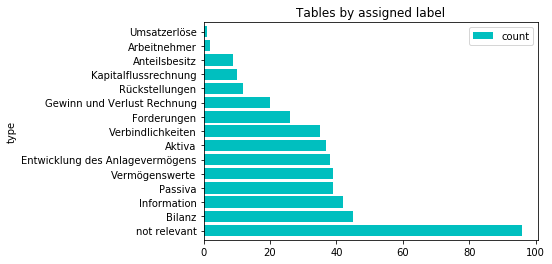

In [5]:
labeled_summary.plot(kind='barh', color='c', width= 0.8)
plt.title("Tables by assigned label")
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

## Disribution of Predicted Labels

In [21]:
#Aggregating the labels
predicted_labels = df_final[['prediction', 'max_prob']].groupby('prediction').count()
predicted_labels.rename(columns={'max_prob':'count'}, inplace=True)
predicted_labels = predicted_labels.sort_values(by=['count'], ascending=False)
predicted_labels

,count
prediction,
Information,889
not relevant,713
Aktiva,618
Passiva,618
Bilanz,342
Entwicklung des Anlagevermögens,198
Verbindlichkeiten,168
Gewinn und Verlust Rechnung,102
Forderungen,92


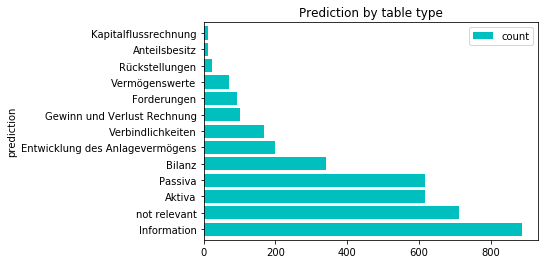

In [7]:
predicted_labels.plot(kind='barh', color='c', width= 0.8)
plt.title("Prediction by table type")
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

## Vectorizing to compare first labeled table with last one

In [10]:
# defining training set and target
df_train_final = df_final.dropna(axis=0) #remove rows which don't have a lable yet
y_train_final = df_final.type.dropna(axis=0)
print(len(df_train_final))

451


In [11]:
# vectorize train set
model = TfidfVectorizer(min_df=0.1) 
tf_train_final = model.fit_transform(df_train_final.content_stemmed) #for training the data

# Random Forest Classifier

In [12]:
#splitting test and training data on 
docs_train, docs_test, y_train, y_test = train_test_split(df_train_final.content_stemmed, # Independent variables
                                                        df_train_final.type,            # Dependent variables
                                                        test_size = 0.20,           # 20% becomes test data
                                                        random_state = 12)          # Identifying the random seed for reproducibility

In [13]:
#Defininf the Pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

#Defininf the Parameters grid
param_grid = {
    'tfidf__max_df':  [0.9, 0.95],
    'tfidf__min_df': [0.1, 0.15],
    'clf__min_samples_leaf': [1, 2, 3, 4], 
    'clf__n_estimators': [10, 20, 50, 100, 200]
}

#Initiating Grid Search
grid_search = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=5) #scoring="precision" instead of scoring="accuracy"
#Fitting the Grid Search
grid_search.fit(docs_train, y_train) 

#Defining model with best parameters
best_rf = grid_search.best_estimator_ 
print(grid_search.best_params_)

C:\Users\Friese\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'clf__min_samples_leaf': 1, 'clf__n_estimators': 50, 'tfidf__max_df': 0.9, 'tfidf__min_df': 0.1}


In [14]:
#Predicting the test results
y_pred_rf = best_rf.predict(docs_test)

#Comparing to actual test results
print(classification_report(y_test, y_pred_rf))

                                 precision    recall  f1-score   support

                         Aktiva       1.00      0.71      0.83         7
                  Anteilsbesitz       1.00      1.00      1.00         1
                   Arbeitnehmer       0.00      0.00      0.00         1
                         Bilanz       0.88      0.78      0.82         9
Entwicklung des Anlagevermögens       0.89      1.00      0.94         8
                    Forderungen       0.62      0.83      0.71         6
    Gewinn und Verlust Rechnung       0.86      1.00      0.92         6
                    Information       1.00      1.00      1.00         8
           Kapitalflussrechnung       1.00      0.75      0.86         4
                        Passiva       0.71      0.62      0.67         8
                 Rückstellungen       1.00      1.00      1.00         5
                   Umsatzerlöse       0.00      0.00      0.00         1
              Verbindlichkeiten       0.83      0.

C:\Users\Friese\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Naive Bayes Classifier

In [15]:
#Vectorizing
model = TfidfVectorizer(min_df=0.1, max_df=0.95)
tf_train = model.fit_transform(docs_train) #for training the data
tf_test = model.transform(docs_test)  #for testing the accuracy

#Feature names
features = model.get_feature_names()

tf_train = pd.DataFrame(data=tf_train.toarray(),
                        index=docs_train.index,    # keeping original idices
                        columns=features)           # feature names as columns
tf_train.head()

,aktiva,and,anlag,anlagevermog,anzahl,auf,aus,bei,betrieb,bilanzsumm,...,sachanlag,sonstig,summ,umlaufvermog,und,unternehm,verbind,verbund,vermogensgegenstand,von
766,0.229765,0.0,0.0,0.213463,0.0,0.0,0.000000,0.213463,0.0,0.488714,...,0.0,0.000000,0.336073,0.214806,0.120075,0.000000,0.000000,0.000000,0.0,0.000000
1726,0.638211,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.339371,...,0.0,0.000000,0.233375,0.298330,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
93,0.000000,0.0,0.0,0.000000,0.0,0.0,0.781768,0.000000,0.0,0.000000,...,0.0,0.623570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
460,0.000000,0.0,0.0,0.000000,0.0,0.0,0.581195,0.000000,0.0,0.000000,...,0.0,0.115896,0.151527,0.000000,0.216556,0.181446,0.147107,0.208702,0.0,0.440699
561,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.269476,0.000000,0.000000,0.000000,0.0,0.000000


In [16]:
# initialize Naive Bayes
nb_final = MultinomialNB() #initialize the Naive Bayes classifier for multinomial models
nb_final.fit(tf_train, y_train) #Fit Naive Bayes classifier according to X, y 

#creating the predictions
y_pred_NB = nb_final.predict(tf_test)

In [17]:
#Comparing to actual test results
print(classification_report(y_test, y_pred_NB))

                                 precision    recall  f1-score   support

                         Aktiva       0.88      1.00      0.93         7
                  Anteilsbesitz       0.00      0.00      0.00         1
                   Arbeitnehmer       0.00      0.00      0.00         1
                         Bilanz       0.80      0.44      0.57         9
Entwicklung des Anlagevermögens       0.80      1.00      0.89         8
                    Forderungen       1.00      0.67      0.80         6
    Gewinn und Verlust Rechnung       0.00      0.00      0.00         6
                    Information       0.89      1.00      0.94         8
           Kapitalflussrechnung       0.00      0.00      0.00         4
                        Passiva       0.71      0.62      0.67         8
                 Rückstellungen       0.00      0.00      0.00         5
                   Umsatzerlöse       0.00      0.00      0.00         1
              Verbindlichkeiten       0.75      0.

C:\Users\Friese\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [18]:
#Initiating LogisticRegression
log_reg_final = LogisticRegression(solver='liblinear', random_state=0, C=5, penalty='l2', max_iter=1000)

#Fitting the model
log_reg_final.fit(tf_train, y_train)

#creating the predictions
y_pred_log_reg = log_reg_final.predict(tf_test)


In [19]:
print(classification_report(y_test, y_pred_log_reg))

                                 precision    recall  f1-score   support

                         Aktiva       0.78      1.00      0.88         7
                  Anteilsbesitz       0.00      0.00      0.00         1
                   Arbeitnehmer       0.00      0.00      0.00         1
                         Bilanz       0.75      0.67      0.71         9
Entwicklung des Anlagevermögens       0.80      1.00      0.89         8
                    Forderungen       0.71      0.83      0.77         6
    Gewinn und Verlust Rechnung       0.83      0.83      0.83         6
                    Information       0.89      1.00      0.94         8
           Kapitalflussrechnung       1.00      0.50      0.67         4
                        Passiva       0.80      0.50      0.62         8
                 Rückstellungen       1.00      1.00      1.00         5
                   Umsatzerlöse       0.00      0.00      0.00         1
              Verbindlichkeiten       0.83      0.

C:\Users\Friese\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
